In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec

In [98]:
df = pd.read_csv('peter-pan.txt', sep='/n', header=None)

/var/folders/ws/7xr4y3vn2nv3l2gxgwhk4y4r0000gn/T/ipykernel_90055/473304629.py:1: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



In [99]:
df.head(5)

,0
0,Chapter I.
1,PETER BREAKS THROUGH
2,"All children, except one, grow up. They soon k..."
3,way Wendy knew was this. One day when she was ...
4,"in a garden, and she plucked another ﬂower and..."


In [100]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 3960


In [101]:
from keras.preprocessing.text import text_to_word_sequence

sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones
# en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también)
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [102]:
sentence_tokens[:2]

[['chapter', 'i'], ['peter', 'breaks', 'through']]

In [103]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [104]:
w2v_model = Word2Vec(min_count=10,
                     window=2,
                     vector_size=200,
                     negative=20,
                     workers=1,
                     sg=1)

In [105]:
w2v_model.build_vocab(sentence_tokens)

In [106]:
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 3960


In [107]:
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de words distintas en el corpus: 541


In [108]:
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=80,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 285898.6875
Loss after epoch 1: 212871.6875
Loss after epoch 2: 219406.1875
Loss after epoch 3: 220011.6875
Loss after epoch 4: 205126.625
Loss after epoch 5: 189944.625
Loss after epoch 6: 189679.625
Loss after epoch 7: 187217.125
Loss after epoch 8: 185804.875
Loss after epoch 9: 183264.75
Loss after epoch 10: 162284.375
Loss after epoch 11: 158691.0
Loss after epoch 12: 159523.75
Loss after epoch 13: 158027.75
Loss after epoch 14: 159239.25
Loss after epoch 15: 158188.5
Loss after epoch 16: 158795.75
Loss after epoch 17: 158392.5
Loss after epoch 18: 156595.25
Loss after epoch 19: 157262.75
Loss after epoch 20: 156708.25
Loss after epoch 21: 155424.0
Loss after epoch 22: 157188.0
Loss after epoch 23: 148820.5
Loss after epoch 24: 142825.5
Loss after epoch 25: 144344.0
Loss after epoch 26: 143825.5
Loss after epoch 27: 143847.0
Loss after epoch 28: 143035.0
Loss after epoch 29: 142277.5
Loss after epoch 30: 143558.5
Loss after epoch 31: 143105.0
Loss after epoch 3

(1832550, 3786480)

In [109]:
w2v_model.wv.most_similar(positive=["peter"], topn=10)

[('he', 0.40603601932525635),
 ('she', 0.37837934494018555),
 ('awfully', 0.3474618196487427),
 ('chapter', 0.3188472092151642),
 ('form', 0.3174370229244232),
 ('immediately', 0.30802473425865173),
 ('herself', 0.30337607860565186),
 ('tinker', 0.30079808831214905),
 ('ship', 0.2954633831977844),
 ('in', 0.29053613543510437)]

In [110]:
w2v_model.wv.most_similar(positive=["wendy"], topn=10)

[('exclaimed', 0.36252474784851074),
 ('chapter', 0.36093127727508545),
 ('i', 0.3396271765232086),
 ('she', 0.3391630947589874),
 ('jane', 0.32710033655166626),
 ('forward', 0.31919723749160767),
 ('her', 0.3156755268573761),
 ('among', 0.3107258677482605),
 ('george', 0.30973753333091736),
 ('mother', 0.3044361472129822)]

In [111]:
w2v_model.wv.most_similar(negative=["soon"])

[('day', 0.06823698431253433),
 ('end', 0.04533625394105911),
 ('feet', 0.03660043701529503),
 ('slightly', 0.03195067122578621),
 ('part', 0.02207288146018982),
 ('arms', 0.01850816234946251),
 ('after', 0.015073028393089771),
 ('adventures', 0.013929609209299088),
 ('left', 0.00816727802157402),
 ('last', 0.005176362115889788)]

In [112]:
from sklearn.manifold import TSNE
import numpy as np

def reduce_dimensions(model):
    num_dimensions = 2

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

In [113]:
import plotly.express as px

x_vals, y_vals, labels = reduce_dimensions(w2v_model)

MAX_WORDS=200
fig = px.scatter(x=x_vals[:MAX_WORDS], y=y_vals[:MAX_WORDS], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # esto para plotly en colab

In [116]:
from sklearn.metrics import pairwise

def plot_matrix_distance(words, dist):
    fig = plt.figure(figsize=(16,9))
    ax = fig.add_subplot()
    sns.heatmap(dist, xticklabels=words, yticklabels=words, annot=True, fmt=".2f", cmap="YlGnBu", ax=ax)
    plt.show()

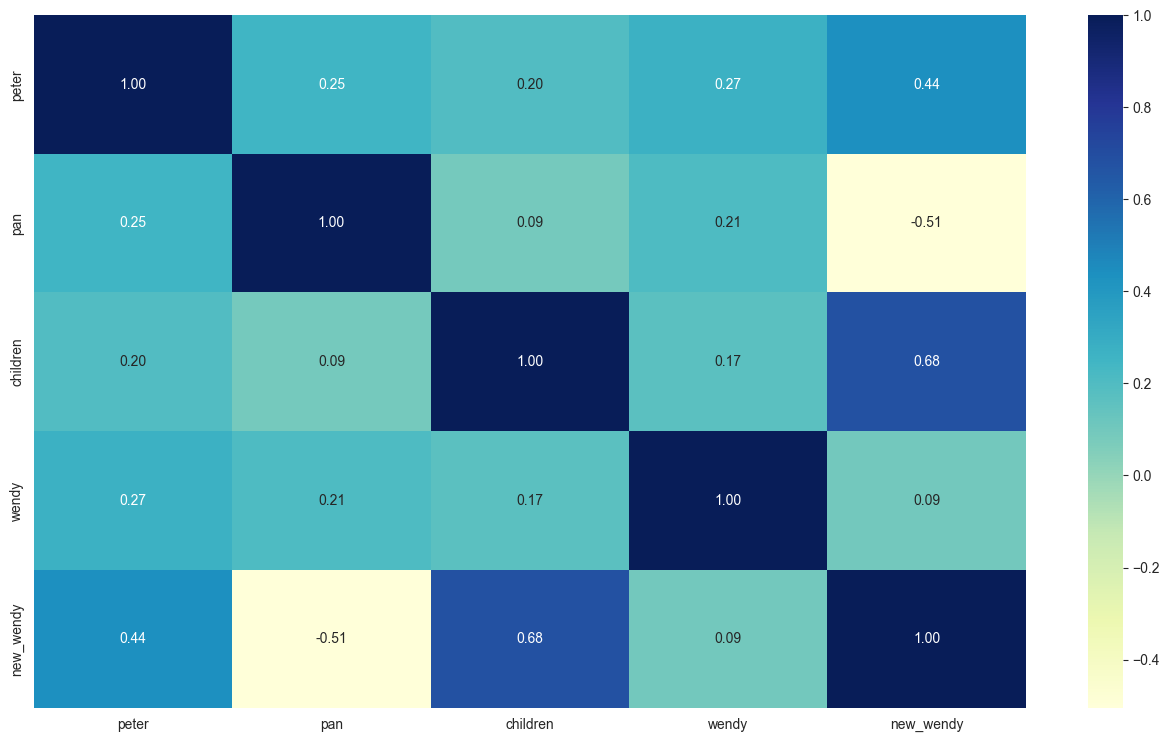

In [120]:
test_words = ['peter', 'pan', 'children', 'wendy']
test_emb = [w2v_model.wv[w] for w in test_words]

new_queen = test_emb[0] - test_emb[1] + test_emb[2]

new_words = test_words + ['new_wendy']
new_emb = np.append(test_emb, new_queen.reshape(1, -1), axis=0)

dist = pairwise.cosine_similarity(new_emb, new_emb)

plot_matrix_distance(new_words, dist)

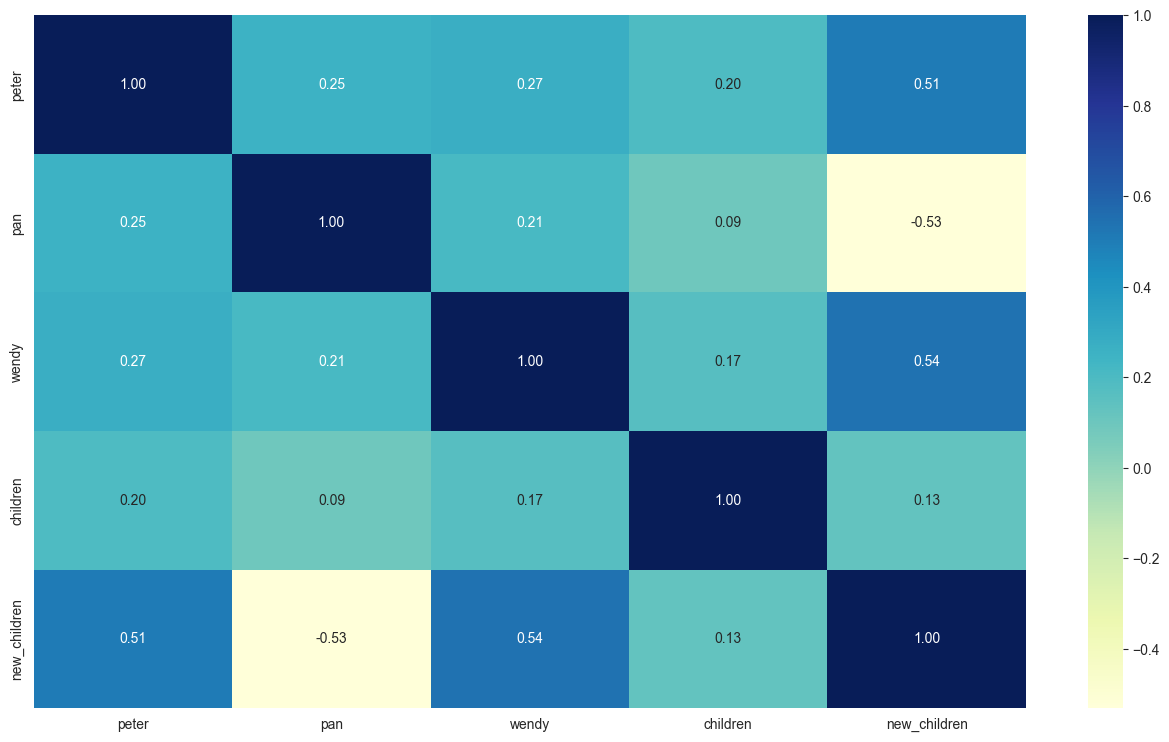

In [121]:
test_words = ['peter', 'pan', 'wendy', 'children']
test_emb = [w2v_model.wv[w] for w in test_words]

new_queen = test_emb[0] - test_emb[1] + test_emb[2]

new_words = test_words + ['new_children']
new_emb = np.append(test_emb, new_queen.reshape(1, -1), axis=0)

dist = pairwise.cosine_similarity(new_emb, new_emb)

plot_matrix_distance(new_words, dist)